# Load coco data

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

dataDir='/data/dataset/coco2014/'
dataType='val2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=5.28s)
creating index...
index created!


In [2]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread(img['coco_url'])

In [3]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=3.60s)
creating index...
index created!


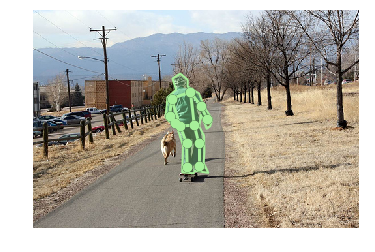

In [4]:
# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [5]:
anns

[{'segmentation': [[228.43,
    247.9,
    229.63,
    206.62,
    224.24,
    191.07,
    220.65,
    179.7,
    207.49,
    169.53,
    202.71,
    163.55,
    205.7,
    133.04,
    218.86,
    121.68,
    213.47,
    104.33,
    225.44,
    96.55,
    236.8,
    106.12,
    236.8,
    116.29,
    254.15,
    127.06,
    263.72,
    150.39,
    274.49,
    166.54,
    271.5,
    177.31,
    266.12,
    181.5,
    257.14,
    159.96,
    254.75,
    177.91,
    261.93,
    192.27,
    262.53,
    216.79,
    261.33,
    234.14,
    268.51,
    249.1,
    247.57,
    246.11,
    245.78,
    249.69,
    229.03,
    248.5]],
  'num_keypoints': 12,
  'area': 5999.5445,
  'iscrowd': 0,
  'keypoints': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   212,
   135,
   2,
   241,
   125,
   2,
   209,
   162,
   2,
   257,
   146,
   2,
   218,
   172,
   2,
   267,
   167,
   2,
   225,
   177,
   2,
   247,
   176,
   2,
   235,
   203,
   2,
   254,

In [6]:
len(anns[0]['keypoints']) / 3

17.0

In [7]:
for id, ann in enumerate(anns):
    s = ann['keypoints']
    x = s[0::3]
    y = s[1::3]
# get valid data
x = x[len(x)-anns[0]['num_keypoints']:]
y = y[len(y)-anns[0]['num_keypoints']:]
y

[135, 125, 162, 146, 172, 167, 177, 176, 203, 204, 240, 238]

# Generate some toy data

In [8]:
import matplotlib.pyplot as plt
np.random.seed(0)
x = [212, 241, 209, 257, 218, 267, 225, 247, 235, 254, 236, 254]
y = [135, 125, 162, 146, 172, 167, 177, 176, 203, 204, 240, 238]
def add_noise(x, level=10):
    
    return x + np.random.randint(low=-level, high=level, size=np.shape(x))

x_noise_low = add_noise(x, level=10)
y_noise_low = add_noise(y, level=10)
x_noise_high = add_noise(x, level=100)
y_noise_high = add_noise(y, level=100)
key_points = np.array(list(zip(x,y)))

In [9]:
x_noise_low

array([214, 246, 199, 250, 211, 264, 224, 256, 243, 248, 232, 256])

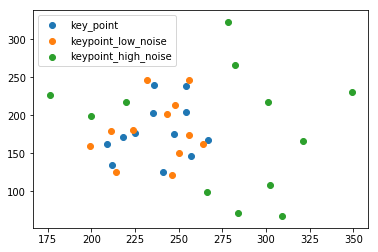

In [10]:
plt.scatter(x, y, label="key_point")
plt.scatter(x_noise_low, y_noise_low, label="keypoint_low_noise")
plt.scatter(x_noise_high, y_noise_high, label="keypoint_high_noise")
plt.legend()
plt.show()

In [11]:
def norm1(v):
#     you can also use numpy.linalg.norm(ord=2, axis=1):
#     return np.linalg.norm(v, ord=2, axis=1)
    return np.sqrt(np.sum(v**2, axis=1))

def measure_distance(x1, y1, x2, y2):
    # 定义有意义的向量 (可以是手，脚的向量)。例子里假设相邻向量为“有意义的”向量
    x1y1 = np.array(list(zip(x1,y1)))
    x2y2 = np.array(list(zip(x2,y2)))
    pose_vectors_1 = x1y1[0:len(x1y1)-1] - x1y1[1:len(x1y1)]
    pose_vectors_2 = x2y2[0:len(x2y2)-1] - x2y2[1:len(x2y2)]

    norm_1_2 = norm1(pose_vectors_1) * norm1(pose_vectors_2)
    cos_similarities = np.sum(pose_vectors_1 * pose_vectors_2, axis=1) / norm_1_2
    cos_similarities = abs(cos_similarities)
    average_cos_similarities = np.average(cos_similarities)
    return cos_similarities, average_cos_similarities

## If two vectors match

In [12]:
x1, x2, y1, y2 = x, y, x, y
cos_sim, average_cos_sim = measure_distance(x1, x2, y1, y2)
print(cos_sim)
print(average_cos_sim)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0


## If two vectors mis-match slightly

In [13]:
x1, x2, y1, y2 = x, y, x_noise_low, y_noise_low
cos_sim, average_cos_sim = measure_distance(x1, x2, y1, y2)
print(cos_sim)
print(average_cos_sim)

[0.98436531 0.98423046 0.98920346 0.99868017 0.97830139 0.98217179
 0.99022651 0.99986477 0.4610788  0.99992565 0.98842479]
0.9414975531065999


## If two vectors mis-match completely

In [14]:
x1, x2, y1, y2 = x, y, x_noise_high, y_noise_high
cos_sim, average_cos_sim = measure_distance(x1, x2, y1, y2)
print(cos_sim)
print(average_cos_sim)

[0.76086906 0.95461374 0.06408816 0.69702641 0.63272091 0.88758442
 0.75744124 0.065624   0.31867019 0.96940384 0.36905018]
0.5888265613755747


## Conclusion

We can find the x_noise_high, y_noise_high has the lowest similarity 0.58 when compared with x, y. Besides, we can find the 0, 5, 7, 9, 10, 12 dimension data [0.76086906 0.06408816 0.69702641 0.63272091 0.75744124 0.065624   0.31867019 0.96940384 0.36905018] are the reasons why the vectors dismatch. For example, these feature might represent "Arm", "Head", or "Legs" vectors...